<a href="https://colab.research.google.com/github/ereny123/Multitasking-MThesis-2024/blob/main/Multitask_model_Validation_on_Single_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [ ]:
#create a model class
class Model(nn.Module):
  #Input (Tasks) random array of 9 units
  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer


    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act
    print("h_act shape:", h_act.shape)
    print("out_act shape:", out_act.shape)

#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break

            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log



# Using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()

    loss.backward()
    optimizer.step()

    return loss.item()



# Define training loop
def train_Rein(model, taskData, stimulusData, targetData, num_episodes=1000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Define optimizer
    losses = [] # To store losses at each episode

    for episode in range(1, num_episodes + 1):
        loss = reinforce_train(model, optimizer, taskData, stimulusData, targetData) # Train using REINFORCE
        losses.append(loss)

        if episode % 100 == 0:  #Logging
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.3f}")

    return losses


In [ ]:
# Generate training data
def generate_dataset_multitask():
    stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *20 , dtype=torch.float)


# Generate task data
    taskDatapattern = torch.tensor([
    [1, 1, 1, 0, 0, 0, 0, 0, 0] , #Task 1
    [1, 1, 0, 1, 0, 0, 0, 0, 0] , #Task 2
    [1, 1, 0, 0, 1, 0, 0, 0, 0] , #Task 3
    [1, 1, 0, 0, 0, 1, 0, 0, 0] , #Task 4
    [1, 1, 0, 0, 0, 0, 1, 0, 0] , #Task 5
    [1, 1, 0, 0, 0, 0, 0, 1, 0] , #Task 6
    [1, 1, 0, 0, 0, 0, 0, 0, 1] , #Task 7
    [1, 0, 1, 0, 0, 0, 0, 0, 1] , #Task 8
    [1, 0, 0, 1, 0, 0, 0, 0, 1] , #Task 9
    [1, 0, 0, 0, 1, 0, 0, 0, 1] , #Task 10
    [1, 0, 0, 0, 0, 1, 0, 0, 1] , #Task 11
    [1, 0, 0, 0, 0, 0, 1, 0, 1] , #Task 12
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 13
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 14
    [0, 1, 0, 0, 0, 0, 0, 1, 1] , #Task 15
    [0, 0, 1, 0, 0, 0, 0, 1, 1] , #Task 16
    [0, 0, 0, 1, 0, 0, 0, 1, 1] , #Task 17
    [0, 0, 0, 0, 1, 0, 0, 1, 1] , #Task 18
    [0, 0, 0, 0, 0, 1, 0, 1, 1] , #Task 19
    [0, 0, 0, 0, 0, 0, 1, 1, 1] ] #Task 20

                          , dtype=torch.float)

    taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern])

#Define target data
    targetData = torch.zeros((540,9), dtype=torch.float)


    for i in range(len(targetData)):
       for j in range(0, len(targetData[i]), 3):
        if taskData[i, j:j+3].sum() > 0:
          targetData[i, j:j+3] = stimulusData[i, j:j+3]


    return stimulusData, taskData, targetData


In [ ]:
(stimulusData, taskData, targetData)  = generate_dataset_multitask()

In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(taskData, stimulusData)

(tensor([[0.1326, 0.1183, 0.0962,  ..., 0.1153, 0.1252, 0.1113],
         [0.1301, 0.1035, 0.0920,  ..., 0.1138, 0.1228, 0.1107],
         [0.1413, 0.1064, 0.0875,  ..., 0.1075, 0.1376, 0.1157],
         ...,
         [0.1409, 0.0960, 0.1001,  ..., 0.0840, 0.1302, 0.1330],
         [0.1430, 0.0913, 0.1026,  ..., 0.0851, 0.1168, 0.1212],
         [0.1551, 0.0939, 0.0977,  ..., 0.0802, 0.1310, 0.1266]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1032, 0.1201, 0.1530,  ..., 0.1427, 0.1559, 0.1449],
         [0.1033, 0.1203, 0.1532,  ..., 0.1425, 0.1568, 0.1448],
         [0.1031, 0.1205, 0.1526,  ..., 0.1426, 0.1558, 0.1453],
         ...,
         [0.1011, 0.1307, 0.1451,  ..., 0.1303, 0.1426, 0.1316],
         [0.1009, 0.1301, 0.1458,  ..., 0.1296, 0.1442, 0.1312],
         [0.1008, 0.1304, 0.1452,  ..., 0.1297, 0.1433, 0.1317]],
        grad_fn=<SigmoidBackward0>))

In [ ]:
MSE_log = trainOnline(model, stimulusData, taskData, targetData, 200000)

100%|██████████| 200000/200000 [18:04<00:00, 184.37it/s, MSE=0.00084]


In [ ]:
#Calculate accuracy of the model
def calculate_accuracy(model, output, targetData):
    with torch.no_grad():
        predicted = (output > 0.5).float()  # Convert to binary outputs
        correct = (predicted == targetData).sum().item()  # Count correct predictions
        total = targetData.numel()  # Total number of elements
        accuracy = correct / total  # Calculate accuracy

    return  accuracy


In [ ]:
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

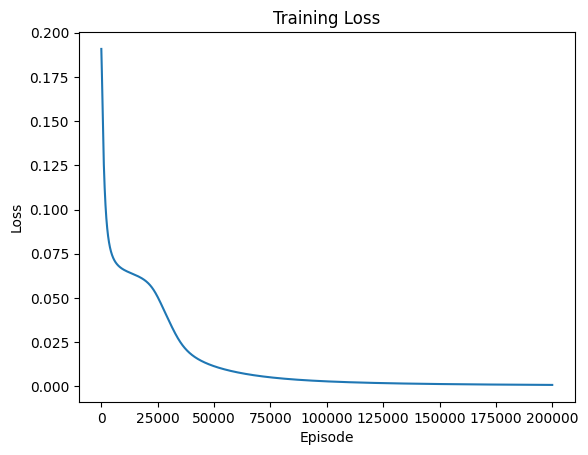

In [ ]:
single_log=plot_losses(MSE_log)

In [ ]:
# Generate validation data
def generate_dataset_validation_ST():
   val_stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *9 , dtype=torch.float)


   val_taskData = torch.tensor ([
     [1, 0, 0, 0, 0, 0, 0, 0, 0] , #Task 1
     [0, 1, 0, 0, 0, 0, 0, 0, 0] , #Task 2
     [0, 0, 1, 0, 0, 0, 0, 0, 0] , #Task 3
     [0, 0, 0, 1, 0, 0, 0, 0, 0] , #Task 4
     [0, 0, 0, 0, 1, 0, 0, 0, 0] , #Task 5
     [0, 0, 0, 0, 0, 1, 0, 0, 0] , #Task 6
     [0, 0, 0, 0, 0, 0, 1, 0, 0] , #Task 7
     [0, 0, 0, 0, 0, 0, 0, 1, 0] , #Task 8
     [0, 0, 0, 0, 0, 0, 0, 0, 1] ]  #Task 9
                                         , dtype=torch.float)


   val_taskData = torch.cat([torch.stack([row] * 27) for row in val_taskData])


   val_targetData = torch.zeros((243,9), dtype=torch.float)

   for i in range(len(val_targetData)):
     if val_taskData[i, :3].sum() > 0:
         val_targetData[i, :3] = val_stimulusData[i, :3]
     elif val_taskData[i, 3:6].sum() > 0:
         val_targetData[i, 3:6] = val_stimulusData[i, 3:6]
     elif val_taskData[i, 6:].sum() > 0:
         val_targetData[i, 6:] = val_stimulusData[i, 6:]


   return val_stimulusData, val_taskData, val_targetData


In [ ]:
val_stimulusData, val_taskData, val_targetData = generate_dataset_validation_ST()

In [ ]:
# Train the model
Loss_reinforce=train_Rein(model, taskData, stimulusData, targetData)

Episode 100/1000 | Loss: 0.080
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.001
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000


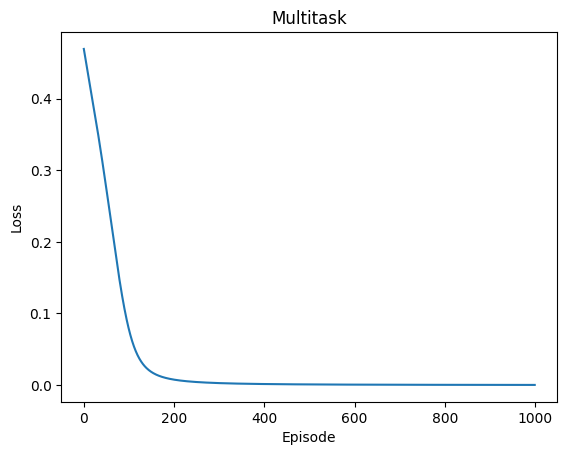

In [ ]:
plot_losses(Loss_reinforce, 'Multitask')

In [ ]:
def evaluate(model, taskData, stimulusData, targetData):
    model.eval()
    with torch.no_grad():
        _, val_output = model(taskData, stimulusData)
        criterion = nn.MSELoss()
        val_loss = criterion(val_output, targetData).item()
    model.train()

    return val_loss


In [ ]:
evaluate(model, val_taskData, val_stimulusData, val_targetData)

In [ ]:
#Calculate accuracy on the validation dataset
def calculate_accuracy(model, val_output, targetData_V):
    with torch.no_grad():
        predicted = (val_output > 0.5).float()  # Convert to binary outputs
        correct = (predicted == targetData_V).sum().item()  # Count correct predictions
        total = targetData.numel()  # Total number of elements
        accuracy = correct / total  # Calculate accuracy

    return  accuracy


In [ ]:
calculate_accuracy(model, val_output, val_targetData)